# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = './data'
data_dir = '../data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

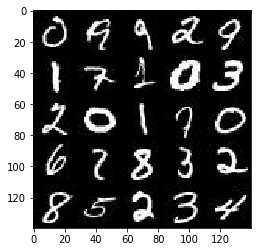

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

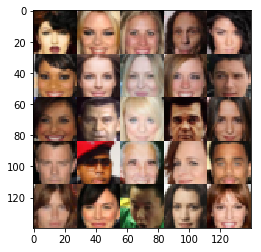

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), "real_input")
    z_input = tf.placeholder(tf.float32, (None, z_dim), "z_input")
    learning_rate = tf.placeholder(tf.float32, None, "learning_rate")
    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function: Hidden layers: conv + batch_norm + leaky ReLU
    alpha = 0.2
    kp = 0.8
    with tf.variable_scope("discriminator", reuse = reuse ):
    # input layer is: 28x28x3 => 14x14x64
        h1 = tf.layers.conv2d(images, 64, 5, strides=2, padding="same", activation=None)
        h1 = tf.maximum(alpha*h1, h1)
    
    # h2 => 7x7x128
        h2 = tf.layers.conv2d(h1, 128, 5, strides=2, padding="same", activation=None)
        h2 = tf.layers.batch_normalization(h2, training=True)
        h2 = tf.maximum(alpha*h2, h2)
        h2 = tf.nn.dropout(h2, kp)
    
    # h3 => 4x3x256
        h3 = tf.layers.conv2d(h2, 256, 5, strides=2, padding="same", activation=None)
        h3 = tf.layers.batch_normalization(h3, training=True)
        h3 = tf.maximum(alpha*h3,h3)   
        h2 = tf.nn.dropout(h3, kp)
        
    # Flatten it 
        flat = tf.reshape(h3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function: Hidden layers: Tconv + batch_norm + leaky ReLU
    alpha = 0.2
    kp = 0.8
    with tf.variable_scope("generator", reuse = not is_train):
    # h1 = fully connected layer
        h1 = tf.layers.dense(z, 2*2*512)
        
    # reshape to start convolutional stack -> 2x2x512
        h1 = tf.reshape(h1, (-1, 2,2, 512))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = tf.maximum(alpha*h1, h1)
    
    # h2 = conv => 7x7x256 - VALID padding
        h2 = tf.layers.conv2d_transpose(h1, 256, 5, strides=2, padding="valid", activation=None)
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.maximum(alpha*h2, h2)
        h2 = tf.nn.dropout(h2, kp) 
        
    # h3 = conv => 14x14x128
        h3 = tf.layers.conv2d_transpose(h2, 128, 5, strides=2, padding="same", activation=None)
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = tf.maximum(alpha*h3, h3)
        h3 = tf.nn.dropout(h3, kp)
    
    # h4 = conv => 14x15x64
        h4 = tf.layers.conv2d_transpose(h3, 64, 5, strides=1, padding="same", activation=None)
        h4 = tf.layers.batch_normalization(h4, training=is_train)
        h4 = tf.maximum(alpha*h4, h4)
        h4 = tf.nn.dropout(h4,kp)

    # output layer = 28x28xout_dim(5)
        logits = tf.layers.conv2d_transpose(h4, out_channel_dim, 5, strides=2, padding="same", activation=None)
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean( 
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1-smooth) ))
    
    d_loss_fake = tf.reduce_mean( 
        tf.nn.sigmoid_cross_entropy_with_logits( logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)  ))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits( logits=d_logits_fake, labels=tf.ones_like(d_model_fake)  ))
    
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get variables 
    t_vars = tf.trainable_variables()
    d_vars = [ var for var in t_vars if var.name.startswith("discriminator")]
    g_vars = [ var for var in t_vars if var.name.startswith("generator")]
    
    # Optimize:
    with tf.control_dependencies( tf.get_collection(tf.GraphKeys.UPDATE_OPS )  ):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    show_every  = 100
    print_every = 10
    steps = 0
    n_images = 16
    losses = []
    

    _, img_width, img_height, img_channels = data_shape
    input_real, input_z, lr = model_inputs(img_width, img_height, img_channels, z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, img_channels)
    d_opt,  g_opt  = model_opt(d_loss, g_loss, learning_rate, beta1)
    saver = tf.train.Saver()

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2

                # 1 - sample random noise 
                sample_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # 2 - Run optimizers 
                _ = sess.run(d_opt, feed_dict={input_z: sample_z, input_real:batch_images, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: sample_z, input_real:batch_images, lr:learning_rate})
                
                # print loss 
                if steps % print_every == 0: 
                        d_loss_tr = d_loss.eval({input_z: sample_z, input_real:batch_images} )
                        g_loss_tr = g_loss.eval({input_z: sample_z} )
                        print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(d_loss_tr),
                          "Generator Loss: {:.4f}".format(g_loss_tr))
                        losses.append((d_loss_tr, g_loss_tr))
                
                # show images
                if steps%show_every == 0:
                    show_generator_output(sess, n_images, input_z, img_channels, data_image_mode)
        saver.save(sess, './model.ckpt')


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.6307... Generator Loss: 2.0126
Epoch 1/2... Discriminator Loss: 0.4804... Generator Loss: 3.2604
Epoch 1/2... Discriminator Loss: 0.5559... Generator Loss: 2.4165
Epoch 1/2... Discriminator Loss: 2.0697... Generator Loss: 4.1710
Epoch 1/2... Discriminator Loss: 1.7442... Generator Loss: 5.2873
Epoch 1/2... Discriminator Loss: 0.5952... Generator Loss: 3.7153
Epoch 1/2... Discriminator Loss: 1.0512... Generator Loss: 0.8586
Epoch 1/2... Discriminator Loss: 0.8460... Generator Loss: 1.4849
Epoch 1/2... Discriminator Loss: 0.4984... Generator Loss: 3.1020
Epoch 1/2... Discriminator Loss: 1.1551... Generator Loss: 0.9124


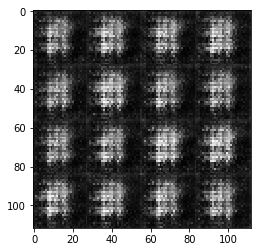

Epoch 1/2... Discriminator Loss: 0.5112... Generator Loss: 4.3671
Epoch 1/2... Discriminator Loss: 0.5072... Generator Loss: 2.7430
Epoch 1/2... Discriminator Loss: 0.6292... Generator Loss: 2.2398
Epoch 1/2... Discriminator Loss: 0.5475... Generator Loss: 2.6350
Epoch 1/2... Discriminator Loss: 0.4688... Generator Loss: 2.8938
Epoch 1/2... Discriminator Loss: 0.5447... Generator Loss: 2.5851
Epoch 1/2... Discriminator Loss: 0.4477... Generator Loss: 3.5302
Epoch 1/2... Discriminator Loss: 0.5389... Generator Loss: 2.9220
Epoch 1/2... Discriminator Loss: 0.5212... Generator Loss: 2.9826
Epoch 1/2... Discriminator Loss: 0.5196... Generator Loss: 2.9784


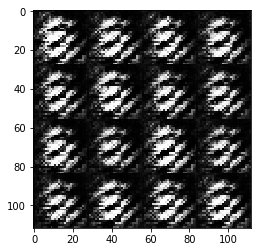

Epoch 1/2... Discriminator Loss: 0.5367... Generator Loss: 2.5012
Epoch 1/2... Discriminator Loss: 0.4942... Generator Loss: 2.6496
Epoch 1/2... Discriminator Loss: 0.4642... Generator Loss: 2.6659
Epoch 1/2... Discriminator Loss: 0.4574... Generator Loss: 3.4252
Epoch 1/2... Discriminator Loss: 0.4973... Generator Loss: 3.4082
Epoch 1/2... Discriminator Loss: 0.4486... Generator Loss: 3.7101
Epoch 1/2... Discriminator Loss: 0.5939... Generator Loss: 2.1572
Epoch 1/2... Discriminator Loss: 0.4971... Generator Loss: 3.2351
Epoch 1/2... Discriminator Loss: 0.7168... Generator Loss: 2.5585
Epoch 1/2... Discriminator Loss: 0.9155... Generator Loss: 3.4728


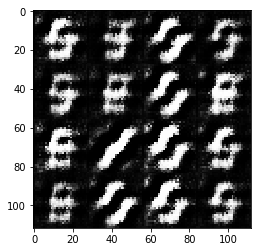

Epoch 1/2... Discriminator Loss: 0.5321... Generator Loss: 2.5777
Epoch 1/2... Discriminator Loss: 0.4696... Generator Loss: 3.2753
Epoch 1/2... Discriminator Loss: 0.7029... Generator Loss: 1.8979
Epoch 1/2... Discriminator Loss: 0.4848... Generator Loss: 3.3672
Epoch 1/2... Discriminator Loss: 0.4671... Generator Loss: 2.8471
Epoch 1/2... Discriminator Loss: 0.4798... Generator Loss: 3.6337
Epoch 1/2... Discriminator Loss: 0.4576... Generator Loss: 3.7518
Epoch 1/2... Discriminator Loss: 0.4935... Generator Loss: 3.8284
Epoch 1/2... Discriminator Loss: 0.4861... Generator Loss: 2.8795
Epoch 1/2... Discriminator Loss: 0.6019... Generator Loss: 4.6887


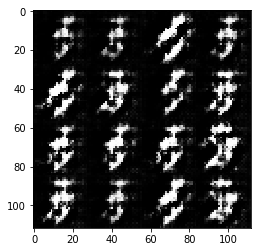

Epoch 1/2... Discriminator Loss: 0.4662... Generator Loss: 3.3640
Epoch 1/2... Discriminator Loss: 0.5063... Generator Loss: 4.2571
Epoch 1/2... Discriminator Loss: 0.4903... Generator Loss: 6.0987
Epoch 1/2... Discriminator Loss: 0.4782... Generator Loss: 3.0958
Epoch 1/2... Discriminator Loss: 0.5299... Generator Loss: 2.9461
Epoch 1/2... Discriminator Loss: 0.5396... Generator Loss: 2.3904
Epoch 2/2... Discriminator Loss: 0.5069... Generator Loss: 3.8402
Epoch 2/2... Discriminator Loss: 0.4849... Generator Loss: 2.9413
Epoch 2/2... Discriminator Loss: 0.5167... Generator Loss: 2.8899
Epoch 2/2... Discriminator Loss: 0.5438... Generator Loss: 3.3655


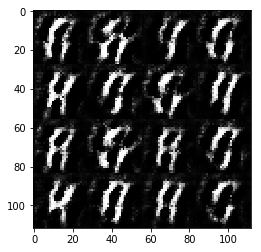

Epoch 2/2... Discriminator Loss: 0.4523... Generator Loss: 3.8164
Epoch 2/2... Discriminator Loss: 0.5234... Generator Loss: 2.7279
Epoch 2/2... Discriminator Loss: 0.4878... Generator Loss: 2.8878
Epoch 2/2... Discriminator Loss: 0.4899... Generator Loss: 3.0644
Epoch 2/2... Discriminator Loss: 0.4747... Generator Loss: 3.0320
Epoch 2/2... Discriminator Loss: 0.5894... Generator Loss: 2.4779
Epoch 2/2... Discriminator Loss: 0.4817... Generator Loss: 3.7168
Epoch 2/2... Discriminator Loss: 0.5887... Generator Loss: 3.8335
Epoch 2/2... Discriminator Loss: 0.5734... Generator Loss: 2.9277
Epoch 2/2... Discriminator Loss: 0.5188... Generator Loss: 2.5102


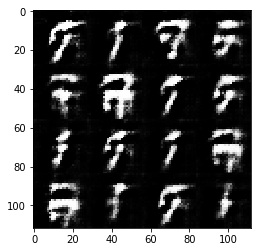

Epoch 2/2... Discriminator Loss: 0.6105... Generator Loss: 2.6571
Epoch 2/2... Discriminator Loss: 0.6796... Generator Loss: 1.9186
Epoch 2/2... Discriminator Loss: 0.5182... Generator Loss: 3.0204
Epoch 2/2... Discriminator Loss: 0.6137... Generator Loss: 3.0090
Epoch 2/2... Discriminator Loss: 0.7318... Generator Loss: 3.1869
Epoch 2/2... Discriminator Loss: 0.6636... Generator Loss: 1.8450
Epoch 2/2... Discriminator Loss: 0.5907... Generator Loss: 2.1733
Epoch 2/2... Discriminator Loss: 0.5587... Generator Loss: 2.9070
Epoch 2/2... Discriminator Loss: 0.5735... Generator Loss: 2.9115
Epoch 2/2... Discriminator Loss: 0.4999... Generator Loss: 3.1150


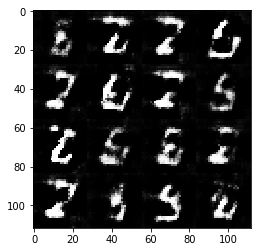

Epoch 2/2... Discriminator Loss: 0.5235... Generator Loss: 3.1391
Epoch 2/2... Discriminator Loss: 0.5925... Generator Loss: 2.2642
Epoch 2/2... Discriminator Loss: 0.7560... Generator Loss: 1.3884
Epoch 2/2... Discriminator Loss: 0.6554... Generator Loss: 1.9845
Epoch 2/2... Discriminator Loss: 0.5217... Generator Loss: 2.9234
Epoch 2/2... Discriminator Loss: 0.6245... Generator Loss: 2.4105
Epoch 2/2... Discriminator Loss: 0.5016... Generator Loss: 3.2011
Epoch 2/2... Discriminator Loss: 0.6297... Generator Loss: 1.8567
Epoch 2/2... Discriminator Loss: 0.5959... Generator Loss: 2.4182
Epoch 2/2... Discriminator Loss: 0.8763... Generator Loss: 3.7496


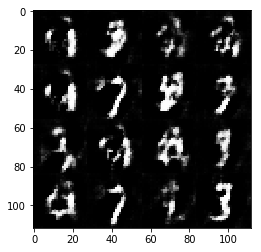

Epoch 2/2... Discriminator Loss: 0.7312... Generator Loss: 2.7970
Epoch 2/2... Discriminator Loss: 0.6479... Generator Loss: 2.0283
Epoch 2/2... Discriminator Loss: 0.6029... Generator Loss: 2.5260
Epoch 2/2... Discriminator Loss: 0.6326... Generator Loss: 2.0921
Epoch 2/2... Discriminator Loss: 0.7238... Generator Loss: 1.6299
Epoch 2/2... Discriminator Loss: 0.5476... Generator Loss: 3.3468
Epoch 2/2... Discriminator Loss: 0.6328... Generator Loss: 2.1644
Epoch 2/2... Discriminator Loss: 0.4814... Generator Loss: 3.1802
Epoch 2/2... Discriminator Loss: 0.5752... Generator Loss: 2.4396
Epoch 2/2... Discriminator Loss: 0.7117... Generator Loss: 3.8011


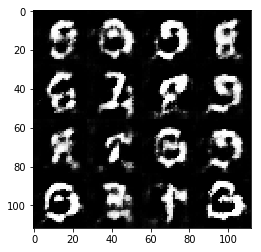

Epoch 2/2... Discriminator Loss: 0.6297... Generator Loss: 2.1403
Epoch 2/2... Discriminator Loss: 0.7499... Generator Loss: 1.5078
Epoch 2/2... Discriminator Loss: 0.9582... Generator Loss: 2.8874


In [12]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.6683... Generator Loss: 2.1478
Epoch 1/1... Discriminator Loss: 0.6011... Generator Loss: 2.6859
Epoch 1/1... Discriminator Loss: 0.4509... Generator Loss: 3.8065
Epoch 1/1... Discriminator Loss: 0.4480... Generator Loss: 3.6519
Epoch 1/1... Discriminator Loss: 0.6668... Generator Loss: 1.6808
Epoch 1/1... Discriminator Loss: 1.1288... Generator Loss: 8.4679
Epoch 1/1... Discriminator Loss: 0.7199... Generator Loss: 5.0697
Epoch 1/1... Discriminator Loss: 0.7314... Generator Loss: 2.2111
Epoch 1/1... Discriminator Loss: 0.7648... Generator Loss: 2.2341
Epoch 1/1... Discriminator Loss: 0.6736... Generator Loss: 3.3031


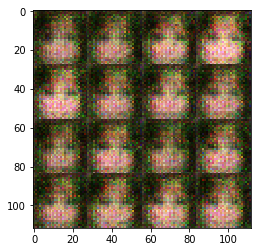

Epoch 1/1... Discriminator Loss: 0.9039... Generator Loss: 1.2204
Epoch 1/1... Discriminator Loss: 0.7169... Generator Loss: 3.2824
Epoch 1/1... Discriminator Loss: 0.9690... Generator Loss: 0.9652
Epoch 1/1... Discriminator Loss: 0.6131... Generator Loss: 2.8350
Epoch 1/1... Discriminator Loss: 0.6055... Generator Loss: 1.8423
Epoch 1/1... Discriminator Loss: 0.5598... Generator Loss: 2.3262
Epoch 1/1... Discriminator Loss: 0.5654... Generator Loss: 2.3755
Epoch 1/1... Discriminator Loss: 0.7399... Generator Loss: 1.6014
Epoch 1/1... Discriminator Loss: 0.7274... Generator Loss: 1.5265
Epoch 1/1... Discriminator Loss: 0.5950... Generator Loss: 3.6976


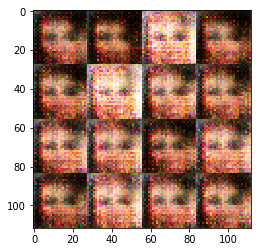

Epoch 1/1... Discriminator Loss: 1.0735... Generator Loss: 0.8528
Epoch 1/1... Discriminator Loss: 0.5541... Generator Loss: 3.5200
Epoch 1/1... Discriminator Loss: 0.8528... Generator Loss: 1.0363
Epoch 1/1... Discriminator Loss: 0.5510... Generator Loss: 2.5583
Epoch 1/1... Discriminator Loss: 0.5801... Generator Loss: 2.7334
Epoch 1/1... Discriminator Loss: 0.9104... Generator Loss: 1.4417
Epoch 1/1... Discriminator Loss: 0.5320... Generator Loss: 2.4365
Epoch 1/1... Discriminator Loss: 0.5045... Generator Loss: 3.8684
Epoch 1/1... Discriminator Loss: 0.6053... Generator Loss: 2.3037
Epoch 1/1... Discriminator Loss: 0.7625... Generator Loss: 1.3495


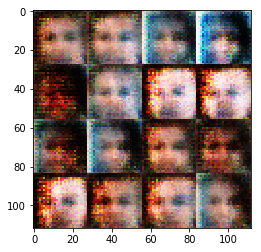

Epoch 1/1... Discriminator Loss: 0.5982... Generator Loss: 2.5535
Epoch 1/1... Discriminator Loss: 0.7332... Generator Loss: 1.5516
Epoch 1/1... Discriminator Loss: 0.8957... Generator Loss: 1.0981
Epoch 1/1... Discriminator Loss: 0.6780... Generator Loss: 2.7582
Epoch 1/1... Discriminator Loss: 0.6509... Generator Loss: 1.7837
Epoch 1/1... Discriminator Loss: 0.5373... Generator Loss: 2.5246
Epoch 1/1... Discriminator Loss: 0.5001... Generator Loss: 2.9975
Epoch 1/1... Discriminator Loss: 0.6882... Generator Loss: 1.5700
Epoch 1/1... Discriminator Loss: 0.5671... Generator Loss: 2.1843
Epoch 1/1... Discriminator Loss: 1.2013... Generator Loss: 4.9632


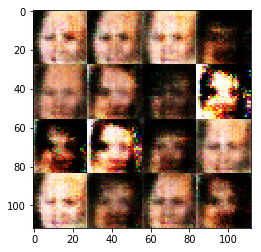

Epoch 1/1... Discriminator Loss: 0.7627... Generator Loss: 3.7808
Epoch 1/1... Discriminator Loss: 0.6566... Generator Loss: 2.0066
Epoch 1/1... Discriminator Loss: 0.8186... Generator Loss: 1.4101
Epoch 1/1... Discriminator Loss: 0.8493... Generator Loss: 3.8359
Epoch 1/1... Discriminator Loss: 0.5331... Generator Loss: 2.3766
Epoch 1/1... Discriminator Loss: 0.7353... Generator Loss: 1.3850
Epoch 1/1... Discriminator Loss: 0.5467... Generator Loss: 2.1578
Epoch 1/1... Discriminator Loss: 0.9060... Generator Loss: 1.2266
Epoch 1/1... Discriminator Loss: 1.1163... Generator Loss: 3.2113
Epoch 1/1... Discriminator Loss: 0.7529... Generator Loss: 3.4600


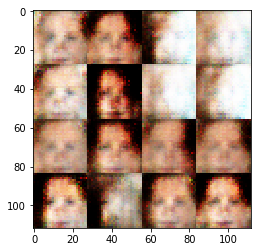

Epoch 1/1... Discriminator Loss: 0.7517... Generator Loss: 2.9297
Epoch 1/1... Discriminator Loss: 0.7633... Generator Loss: 1.6187
Epoch 1/1... Discriminator Loss: 0.8327... Generator Loss: 1.3379
Epoch 1/1... Discriminator Loss: 0.6796... Generator Loss: 1.8944
Epoch 1/1... Discriminator Loss: 0.7837... Generator Loss: 1.5314
Epoch 1/1... Discriminator Loss: 0.8124... Generator Loss: 1.5493
Epoch 1/1... Discriminator Loss: 0.6404... Generator Loss: 1.8398
Epoch 1/1... Discriminator Loss: 0.8111... Generator Loss: 1.3349
Epoch 1/1... Discriminator Loss: 0.5721... Generator Loss: 2.2895
Epoch 1/1... Discriminator Loss: 0.8432... Generator Loss: 3.5860


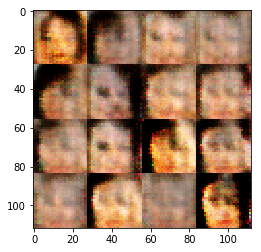

Epoch 1/1... Discriminator Loss: 0.5281... Generator Loss: 2.5721
Epoch 1/1... Discriminator Loss: 1.4182... Generator Loss: 5.8078
Epoch 1/1... Discriminator Loss: 0.7099... Generator Loss: 2.1679
Epoch 1/1... Discriminator Loss: 0.7597... Generator Loss: 2.1107
Epoch 1/1... Discriminator Loss: 0.6099... Generator Loss: 1.9249
Epoch 1/1... Discriminator Loss: 0.7361... Generator Loss: 1.8566
Epoch 1/1... Discriminator Loss: 0.9985... Generator Loss: 0.8670
Epoch 1/1... Discriminator Loss: 0.6341... Generator Loss: 2.9148
Epoch 1/1... Discriminator Loss: 0.6833... Generator Loss: 2.4224
Epoch 1/1... Discriminator Loss: 0.7295... Generator Loss: 2.4444


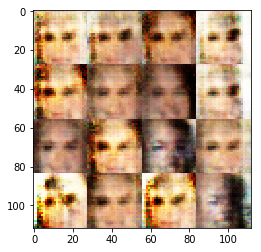

Epoch 1/1... Discriminator Loss: 0.6687... Generator Loss: 2.5224
Epoch 1/1... Discriminator Loss: 0.6050... Generator Loss: 2.3783
Epoch 1/1... Discriminator Loss: 0.8579... Generator Loss: 3.1405
Epoch 1/1... Discriminator Loss: 0.7004... Generator Loss: 3.9351
Epoch 1/1... Discriminator Loss: 0.8837... Generator Loss: 1.8334
Epoch 1/1... Discriminator Loss: 1.1041... Generator Loss: 3.6455
Epoch 1/1... Discriminator Loss: 0.7488... Generator Loss: 1.6989
Epoch 1/1... Discriminator Loss: 0.7604... Generator Loss: 1.8967
Epoch 1/1... Discriminator Loss: 0.7755... Generator Loss: 2.1926
Epoch 1/1... Discriminator Loss: 0.6729... Generator Loss: 1.7739


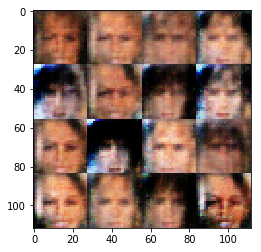

Epoch 1/1... Discriminator Loss: 0.7497... Generator Loss: 1.6590
Epoch 1/1... Discriminator Loss: 0.4784... Generator Loss: 2.9963
Epoch 1/1... Discriminator Loss: 1.1523... Generator Loss: 0.7297
Epoch 1/1... Discriminator Loss: 0.7109... Generator Loss: 2.6327
Epoch 1/1... Discriminator Loss: 1.1069... Generator Loss: 0.9535
Epoch 1/1... Discriminator Loss: 0.8287... Generator Loss: 1.5882
Epoch 1/1... Discriminator Loss: 0.7950... Generator Loss: 2.8359
Epoch 1/1... Discriminator Loss: 0.6393... Generator Loss: 3.1582
Epoch 1/1... Discriminator Loss: 0.7555... Generator Loss: 1.9526
Epoch 1/1... Discriminator Loss: 0.7022... Generator Loss: 1.7485


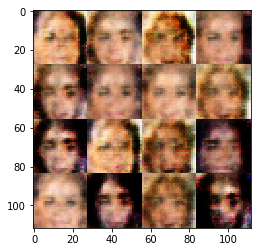

Epoch 1/1... Discriminator Loss: 0.6512... Generator Loss: 2.3915
Epoch 1/1... Discriminator Loss: 1.0076... Generator Loss: 3.6492
Epoch 1/1... Discriminator Loss: 0.6389... Generator Loss: 2.8226
Epoch 1/1... Discriminator Loss: 0.7687... Generator Loss: 1.8133
Epoch 1/1... Discriminator Loss: 0.6825... Generator Loss: 2.1648
Epoch 1/1... Discriminator Loss: 0.7343... Generator Loss: 1.5110
Epoch 1/1... Discriminator Loss: 0.8249... Generator Loss: 1.4694
Epoch 1/1... Discriminator Loss: 0.6397... Generator Loss: 1.8859
Epoch 1/1... Discriminator Loss: 0.7581... Generator Loss: 1.7650
Epoch 1/1... Discriminator Loss: 0.6432... Generator Loss: 2.0902


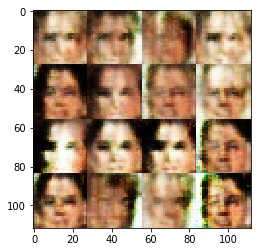

Epoch 1/1... Discriminator Loss: 0.8419... Generator Loss: 1.2872
Epoch 1/1... Discriminator Loss: 0.8272... Generator Loss: 1.2680
Epoch 1/1... Discriminator Loss: 0.6975... Generator Loss: 1.9777
Epoch 1/1... Discriminator Loss: 0.6946... Generator Loss: 2.4665
Epoch 1/1... Discriminator Loss: 0.7029... Generator Loss: 1.8420
Epoch 1/1... Discriminator Loss: 0.9433... Generator Loss: 3.7351
Epoch 1/1... Discriminator Loss: 0.7795... Generator Loss: 3.4184
Epoch 1/1... Discriminator Loss: 0.7343... Generator Loss: 1.7969
Epoch 1/1... Discriminator Loss: 0.6940... Generator Loss: 1.8793
Epoch 1/1... Discriminator Loss: 0.6689... Generator Loss: 1.9662


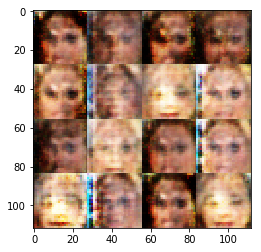

Epoch 1/1... Discriminator Loss: 0.7165... Generator Loss: 1.9045
Epoch 1/1... Discriminator Loss: 0.8071... Generator Loss: 1.5600
Epoch 1/1... Discriminator Loss: 0.7523... Generator Loss: 1.8212
Epoch 1/1... Discriminator Loss: 0.7327... Generator Loss: 2.0689
Epoch 1/1... Discriminator Loss: 0.6404... Generator Loss: 2.2233
Epoch 1/1... Discriminator Loss: 0.7557... Generator Loss: 2.3937
Epoch 1/1... Discriminator Loss: 0.7460... Generator Loss: 2.4514
Epoch 1/1... Discriminator Loss: 0.7857... Generator Loss: 2.1239
Epoch 1/1... Discriminator Loss: 0.7042... Generator Loss: 2.2275
Epoch 1/1... Discriminator Loss: 0.8565... Generator Loss: 2.6616


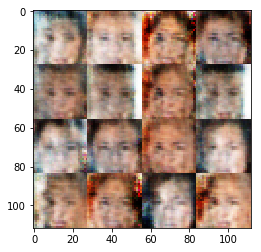

Epoch 1/1... Discriminator Loss: 0.7336... Generator Loss: 1.7683
Epoch 1/1... Discriminator Loss: 0.7945... Generator Loss: 1.4954
Epoch 1/1... Discriminator Loss: 0.7345... Generator Loss: 2.0107
Epoch 1/1... Discriminator Loss: 0.6448... Generator Loss: 2.5810
Epoch 1/1... Discriminator Loss: 0.8808... Generator Loss: 4.3090
Epoch 1/1... Discriminator Loss: 0.8037... Generator Loss: 1.4537
Epoch 1/1... Discriminator Loss: 0.6442... Generator Loss: 2.1592
Epoch 1/1... Discriminator Loss: 0.9696... Generator Loss: 1.1224
Epoch 1/1... Discriminator Loss: 0.8418... Generator Loss: 1.3698
Epoch 1/1... Discriminator Loss: 0.8680... Generator Loss: 2.0461


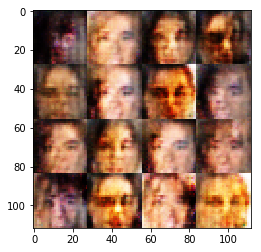

Epoch 1/1... Discriminator Loss: 0.7086... Generator Loss: 1.8655
Epoch 1/1... Discriminator Loss: 0.7210... Generator Loss: 1.9213
Epoch 1/1... Discriminator Loss: 0.9489... Generator Loss: 1.2713
Epoch 1/1... Discriminator Loss: 0.6487... Generator Loss: 2.4894
Epoch 1/1... Discriminator Loss: 1.0283... Generator Loss: 1.0024
Epoch 1/1... Discriminator Loss: 0.8197... Generator Loss: 2.3483
Epoch 1/1... Discriminator Loss: 0.6778... Generator Loss: 2.3566
Epoch 1/1... Discriminator Loss: 0.6901... Generator Loss: 2.8362
Epoch 1/1... Discriminator Loss: 0.6571... Generator Loss: 2.4443
Epoch 1/1... Discriminator Loss: 0.8656... Generator Loss: 3.3572


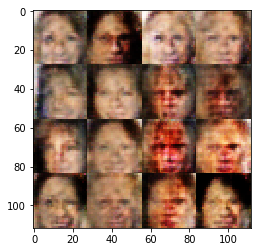

Epoch 1/1... Discriminator Loss: 0.7339... Generator Loss: 1.6839
Epoch 1/1... Discriminator Loss: 0.7080... Generator Loss: 2.5690
Epoch 1/1... Discriminator Loss: 1.4326... Generator Loss: 0.6104
Epoch 1/1... Discriminator Loss: 0.8180... Generator Loss: 2.0134
Epoch 1/1... Discriminator Loss: 0.6410... Generator Loss: 2.2007
Epoch 1/1... Discriminator Loss: 0.8113... Generator Loss: 1.7163
Epoch 1/1... Discriminator Loss: 0.7364... Generator Loss: 2.2806
Epoch 1/1... Discriminator Loss: 0.7066... Generator Loss: 2.3704
Epoch 1/1... Discriminator Loss: 0.8178... Generator Loss: 2.3340
Epoch 1/1... Discriminator Loss: 0.7457... Generator Loss: 1.9197


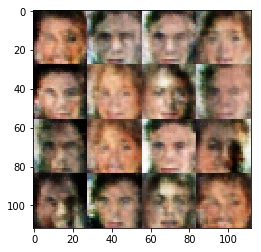

Epoch 1/1... Discriminator Loss: 0.7204... Generator Loss: 2.3055
Epoch 1/1... Discriminator Loss: 0.7681... Generator Loss: 2.7772
Epoch 1/1... Discriminator Loss: 0.8787... Generator Loss: 1.5353
Epoch 1/1... Discriminator Loss: 0.9600... Generator Loss: 2.5938
Epoch 1/1... Discriminator Loss: 0.7964... Generator Loss: 2.1447
Epoch 1/1... Discriminator Loss: 0.9805... Generator Loss: 1.0730
Epoch 1/1... Discriminator Loss: 0.7486... Generator Loss: 2.7418
Epoch 1/1... Discriminator Loss: 0.7622... Generator Loss: 2.6848


In [13]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.